In [1]:
# Distributed Training using TensorFlow

# The tf.distribute.Strategy API provides an abstraction for distributing your training
# across multiple processing units. The goal is to allow users to enable distributed
# training using existing models and training code, with minimal changes.

In [2]:
# Import TensorFlow
import tensorflow as tf
import tensorflow_datasets as tfds
import os
print(tf.__version__)

2.13.0


In [3]:
default_strategy = tf.distribute.get_strategy()
default_strategy

In [26]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [29]:
# We will be looking one of the distributed training method.
# The tf.distribute.MirroredStrategy, which does in-graph replication with synchronous
# training on many GPUs on one machine. It works best with tf.function
# Efficient all-reduce algorithms are used to communicate the variable updates across the devices

# By default, it uses NVIDIA NCCL (NVIDIA Collective Communications Library) as
# the all-reduce implementation.

GPU_devices_list = tf.config.list_physical_devices('GPU')

if GPU_devices_list:
  if len(GPU_devices_list)==1:
    # strategy to place all variables and computation on a single specified device
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  else:
    strategy = tf.distribute.MirroredStrategy()

  # We can provide other cross device communication method too
  """
  mirrored_strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    """
else:  # use default strategy like running on CPU
  strategy = tf.distribute.get_strategy()

print(strategy)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [30]:
# Loads the standard MNIST dataset into a tf.data.Dataset
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples

In [31]:
# Defining Hyperparameters

BUFFER_SIZE = 10000
# batch size
BATCH_SIZE_PER_REPLICA = 64
# batch size (also called global_batch_size) when training on multiple GPUs
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [32]:
# Data Augmentation methods
def scaling(image, label):
  image = tf.cast(image, tf.float32)
  image = image/127.5 - 1
  return image, label


In [33]:
# create input dataset pipeline
train_dataset = mnist_train.map(scaling).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
eval_dataset = mnist_test.map(scaling).batch(BATCH_SIZE)

In [34]:
# define the simple Convolution model funtion
def create_model(IMG_SIZE):
  conv_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  return conv_model

In [35]:
# define and Move the creation of Keras model, optimizer and metrics inside
# Model creation and Optimizer, Metrics definition should be within the scope.

with strategy.scope():
  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
  metric = tf.keras.metrics.SparseCategoricalAccuracy()
  optimizer = tf.keras.optimizers.Adam()

  model = create_model(IMG_SIZE=28)
  model.compile(
      optimizer=optimizer,
      loss=loss_fn,
      metrics=metric
  )

In [36]:
# Define Learning Rate Scheduler
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [37]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [38]:
# Define callbacks
callbacks = [ tf.keras.callbacks.LearningRateScheduler(decay),
             PrintLR()
]

In [39]:
# Let's run the training step on training dataset. This step is the same whether
# you are distributing (strategy) the training or not.
model.fit(train_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
933/938 [============================>.] - ETA: 0s - loss: 0.2014 - sparse_categorical_accuracy: 0.9414
Learning rate for epoch 1 is 0.0010000000474974513
938/938 [==============================] - 11s 9ms/step - loss: 0.2008 - sparse_categorical_accuracy: 0.9416 - lr: 0.0010
Epoch 2/20
925/938 [============================>.] - ETA: 0s - loss: 0.0706 - sparse_categorical_accuracy: 0.9785
Learning rate for epoch 2 is 0.0010000000474974513
938/938 [==============================] - 4s 4ms/step - loss: 0.0702 - sparse_categorical_accuracy: 0.9786 - lr: 0.0010
Epoch 3/20
936/938 [============================>.] - ETA: 0s - loss: 0.0501 - sparse_categorical_accuracy: 0.9848
Learning rate for epoch 3 is 0.0010000000474974513
938/938 [==============================] - 4s 5ms/step - loss: 0.0501 - sparse_categorical_accuracy: 0.9848 - lr: 0.0010
Epoch 4/20
930/938 [============================>.] - ETA: 0s - loss: 0.0267 - sparse_categorical_accuracy: 0.9925
Learning rate for epoch

In [40]:
eval_loss, eval_acc = model.evaluate(eval_dataset)

157/157 [==============================] - 1s 8ms/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9870


In [41]:
print('Eval loss: {}, Eval accuracy: {}'.format(eval_loss, eval_acc))

Eval loss: 0.03976801782846451, Eval accuracy: 0.9869999885559082


In [45]:
# From manual observation
# 1. default_strategy
default_strategy_training_time = [27]*20
default_strategy_training_time[0] = 35
default_strategy_training_time[1] = 31
default_strategy_training_time[-1] = 28

# 2. OneDevice Strategy
onedevice_strategy_training_time = [4]*20
onedevice_strategy_training_time[0] = 9

# 3. MirroredStrategy
mirrored_strategy_training_time = [5]*20
mirrored_strategy_training_time[0] = 8

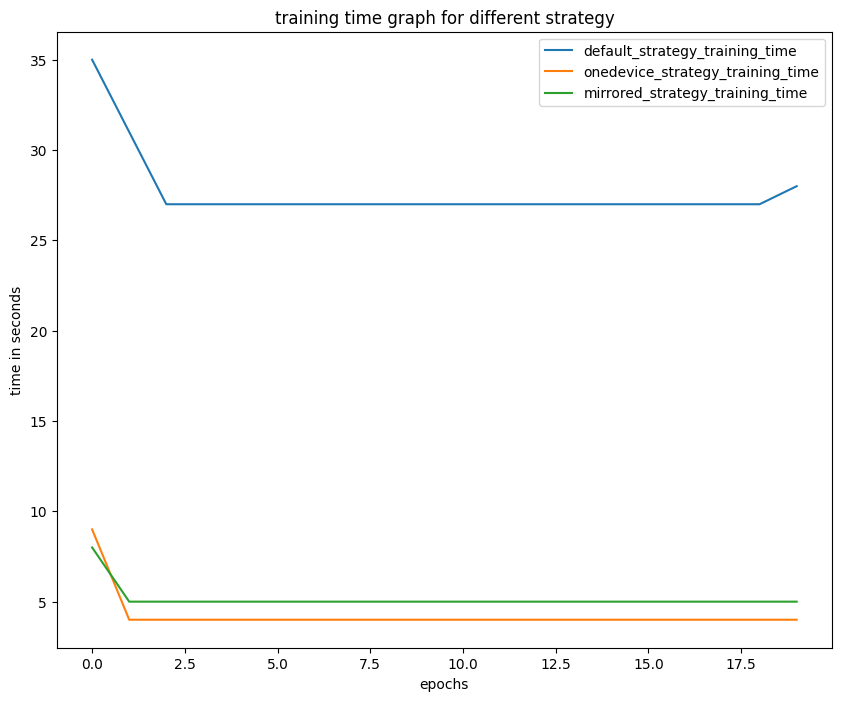

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.title("training time graph for different strategy")
plt.plot(default_strategy_training_time, label="default_strategy_training_time")
plt.plot(onedevice_strategy_training_time, label="onedevice_strategy_training_time")
plt.plot(mirrored_strategy_training_time, label="mirrored_strategy_training_time")

plt.xlabel("epochs")
plt.ylabel("time in seconds")
plt.legend()

In [ ]:
# Saving and Loading model in distribute strategy
"""
There are two kinds of APIs for saving and loading a Keras model:
1. high-level (tf.keras.Model.save and tf.keras.models.load_model) # (.keras zip archive format)
2. low-level (tf.saved_model.save and tf.saved_model.load).   # (TF SavedModel format)

Note that you can get a Keras model back only if you saved a Keras model.

"""

path = '/tmp/tf_save.keras'

# Save the entire model as a SavedModel.
model.save(path)

In [ ]:
# Loading the model
# Here, model can be loaded with or without any distributed strategy
restored_tf_model = tf.keras.models.load_model(path)

# After restoring the model, you can continue training on it, even without needing
# to call Model.compile again, since it was already compiled before saving.
restored_tf_model.fit(train_dataset, epochs=2)

In [ ]:
# Loading model with Strategy

# Note: The strategy used here does not have to be the same strategy used before saving.
another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  restored_tf_model_ds = tf.keras.models.load_model(path)
  restored_tf_model_ds.fit(train_dataset, epochs=2)

In [ ]:
#*******************
# Important Points
"""
1. Model, loss_fun, optimizer, metrics and compile should be initiated within the
   scope of strategy only.

2. All the variables and the model graph are replicated across the replicas. Input is
   evenly distributed across the replicas.

3. All the code can be put inside a single scope.

"""